In [ ]:
# for DFA
'''
    states
    Initial State
    Final States
    input_symbols
    transition Function
'''

# i have installed
# brew install graphviz
# install coloraide and pygraphviz
# visual-automata and automaton for plotting graph

'\n    states\n    Initial State\n    Final States\n    input_symbols\n    transition Function\n'

cat = Accepted
dog = Accepted
A = Not Accepted
zebra = Accepted
dog1 = Not Accepted
1dog = Not Accepted
DogHouse = Not Accepted
Dog_house = Not Accepted
 cats = Accepted
!do@g = Not Accepted


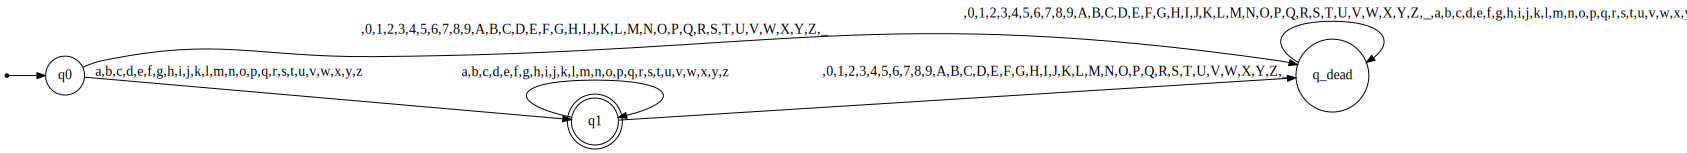

In [1]:
from visual_automata.fa.dfa import DFA

# Define DFA
dfa = DFA(
    states={"q0", "q1", "q_dead"},
    input_symbols=set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789_ "),
    transitions={
        "q0": {ch: "q1" if ch.islower() else "q_dead" for ch in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789_ "},
        "q1": {ch: "q1" if ch.islower() else "q_dead" for ch in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789_ "},
        "q_dead": {ch: "q_dead" for ch in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789_ "}
    },
    initial_state="q0",
    final_states={"q1"},
)

test_words = ["cat", "dog", "A", "zebra", "dog1", "1dog", "DogHouse", "Dog_house", " cats", "!do@g"]

for word in test_words:
    result = "Accepted" if dfa.accepts_input(word.strip()) else "Not Accepted"
    print(f"{word} = {result}")

dfa.show_diagram()  # Visualize the DFA

# Q2

In [10]:
from typing import Set, Tuple
import os
import sys
import re

In [11]:
SIBILANT_ENDINGS = ("s", "z", "x")
DOUBLE_CHAR_SIBILANTS = ("ch", "sh")

In [12]:
def analyze_word(surface: str, lexicon: Set[str]) -> Tuple[bool, str]:
    """
    Analyze surface form `surface` using the lexicon (set of valid roots).
    Returns (accepted, output_string). If accepted == False, output_string == "Invalid Word".
    """
    s = surface.lower().strip()
    if not s:
        return False, "Invalid Word"
    
    # 1) Exact root match -> singular
    if s in lexicon:
        return True, f"{s}+N+SG"
    
    # Helper to check sibilant ending for a root
    def is_sibilant_root(root: str) -> bool:
        if any(root.endswith(x) for x in DOUBLE_CHAR_SIBILANTS):
            return True
        if any(root.endswith(x) for x in SIBILANT_ENDINGS):
            return True
        return False
    
    # 2) y -> ies : surface endswith 'ies', root = surface[:-3] + 'y'
    if s.endswith("ies") and len(s) > 3:
        stem = s[:-3] + "y"
        # ensure the original root had consonant+y (approx): the char before y in root should be a consonant
        # That means surface[-4] exists and is a consonant.
        if len(s) >= 4:
            before_y = s[-4]
            if before_y not in "aeiou":
                # accept only if stem in lexicon
                if stem in lexicon:
                    return True, f"{stem}+N+PL"
                # else continue to check other rules -> ultimately invalid
        # If it fails the consonant test or not in lexicon -> invalid for this rule
    
    # 3) es (e-insertion) : surface endswith 'es' and root would be surface[:-2]
    if s.endswith("es") and len(s) > 2:
        candidate_root = s[:-2]
        # We allow this rule only if candidate_root ends with sibilant endings OR 'o' (optional)
        if (is_sibilant_root(candidate_root) or candidate_root.endswith("o")):
            if candidate_root in lexicon:
                return True, f"{candidate_root}+N+PL"
            else:
                # If candidate root not in lexicon, do not accept; this path rejects.
                pass
    
    # 4) s (regular) : surface endswith 's' and root = surface[:-1]
    if s.endswith("s") and len(s) > 1:
        candidate_root = s[:-1]
        # Do not allow this rule when root endswith 'y' (should be 'ies'), or when root is sibilant (should be 'es')
        if candidate_root.endswith("y"):
            # e.g., 'trys' is invalid (should be 'tries')
            pass
        elif is_sibilant_root(candidate_root):
            # e.g., 'foxs' invalid (should be 'foxes')
            pass
        else:
            if candidate_root in lexicon:
                return True, f"{candidate_root}+N+PL"
    
    # If none matched or lexicon check failed -> Invalid Word
    return False, "Invalid Word"

In [13]:
LEXICON_FILENAME = "brown_nouns.txt"

In [14]:
def load_lexicon(filename: str) -> Set[str]:
    """
    Load the lexicon from a file with one token per line.
    Performs simple normalization to lowercase and strips whitespace.
    Returns a set of tokens.
    """
    lex = set()
    try:
        with open(filename, "r", encoding="utf-8") as f:
            for line in f:
                token = line.strip().lower()
                if token:
                    lex.add(token)
        return lex
    except FileNotFoundError:
        return set()

In [15]:
def main_process(all_tokens):
    # For the analyzer, the lexicon should ideally contain singular root forms.
    # If the provided brown_nouns.txt includes inflected forms and plurals, a better approach
    # is to derive the root set first by selecting tokens that appear to be singular, or by
    # having a separate list of lemma forms. Here we assume the supplied list primarily contains roots.
    lexicon = load_lexicon(LEXICON_FILENAME)
    if not lexicon:
        print("Note: 'brown_nouns.txt' not found — using builtin sample lexicon for demonstration.\n")
        # Small builtin sample lexicon of common roots for demonstration
        lexicon = {
            "fox", "watch", "try", "bag", "cat", "dog", "hero", "potato", "analysis", "bus", "wish", "box", "quiz",
            "boy", "toy", "church", "leaf", "life", "wife", "city", "baby", "key", "hero", "photo", "piano"
        }
        # Also include some plurals if present as roots (some nouns are invariant)
        lexicon.update(["sheep", "series", "species", "deer"])
    
    outputs = []
    for token in all_tokens:
        token = token.strip()
        if not token:
            continue
        ok, out = analyze_word(token, lexicon)
        if ok:
            outputs.append(f"{token} = {out}")
        else:
            outputs.append(f"{token} = Invalid Word")
    return outputs

# If brown_nouns.txt exists, we will analyze every token inside it; otherwise, we'll use a small test set
if os.path.exists(LEXICON_FILENAME):
    with open(LEXICON_FILENAME, "r", encoding="utf-8") as f:
        tokens_to_check = [line.strip() for line in f if line.strip()]
else:
    # Example input tokens (can be substituted with your full noun list before submission)
    tokens_to_check = [
        "foxes", "fox", "foxs", "watches", "watch", "tries", "try", "bags", "bag",
        "churches", "church", "churchs", "heroes", "hero", "potatoes", "potato",
        "boys", "boy", "keys", "key", "photos", "photo", "pianos", "piano",
        "series", "species", "deer", "sheep", "analysis", "analyses", "city", "cities",
        "leafs", "leaves", "life", "lives", "quizs", "quizzes"
    ]

results = main_process(tokens_to_check)

# Print outputs — ready to copy/paste into your submission file
print("\n".join(results))

# Also save to a file for convenience
out_filename = "brown_nouns_analysis_output.txt"
with open(out_filename, "w", encoding="utf-8") as outf:
    outf.write("\n".join(results))

print(f"\nSaved analysis to '{out_filename}'.")


investigation = investigation+N+SG
primary = primary+N+SG
election = election+N+SG
evidence = evidence+N+SG
irregularities = irregularities+N+SG
place = place+N+SG
jury = jury+N+SG
presentments = presentments+N+SG
charge = charge+N+SG
election = election+N+SG
praise = praise+N+SG
thanks = thanks+N+SG
manner = manner+N+SG
election = election+N+SG
term = term+N+SG
jury = jury+N+SG
reports = reports+N+SG
irregularities = irregularities+N+SG
primary = primary+N+SG
handful = handful+N+SG
reports = reports+N+SG
jury = jury+N+SG
interest = interest+N+SG
election = election+N+SG
number = number+N+SG
voters = voters+N+SG
size = size+N+SG
city = city+N+SG
jury = jury+N+SG
registration = registration+N+SG
election = election+N+SG
laws = laws+N+SG
legislators = legislators+N+SG
laws = laws+N+SG
end = end+N+SG
jury = jury+N+SG
number = number+N+SG
topics = topics+N+SG
departments = departments+N+SG
practices = practices+N+SG
interest = interest+N+SG
governments = governments+N+SG
jury = jury+N+SG
o